In [2]:
from typing import Optional, Callable

import numpy as np
from matplotlib import pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
from scipy.stats import chi2, norm, gumbel_r

from statsmodels.graphics.gofplots import qqplot
from pathlib import Path
import pickle

from lrv_test import LRV
from lrv_test.types import real_function
from statsmodels.graphics.gofplots import qqplot

from scipy.stats import norm

from data_generation.arma import generate_arma_sample
from data_generation.spectral_density import arma_spectral_density
from data_generation.noise import (
    gaussian_sample,
    students_t_sample,
    compound_gaussian_sample,
)

import seaborn as sns

sns.set_style("whitegrid")

# Limit distribution check

In [3]:
def run(
    f: real_function,
    N: int,
    M: int,
    B: int,
    ar: float,
    ma: float,
    freqs: np.ndarray,
    noise_func: Callable,
    oracle_sd: Optional[real_function] = None,
    L: Optional[int] = None,
    noise_params: Optional[dict] = {},
) -> dict:
    is_complex_gaussian = True
    y = generate_arma_sample(
        N, M, ar, ma, is_complex_gaussian, noise_func, noise_params
    )
    lrv_result = LRV(y, B, f, freqs=freqs, L=L, sd=oracle_sd)
    return {
        "lrv": lrv_result,
        # "y": y,
        "freqs": freqs,
        "N": N,
        "M": M,
        "B": B,
        "ar": ar,
        "ma": ma,
        "noise_func": noise_func.__name__,
        "oracle_sd": oracle_sd.__name__ if oracle_sd else None,
        "L": L,
        **noise_params,
    }

In [4]:
# Define once properties of the arma process to generate
N, B, M = 10_000, 301, 120
# N, B, M = 1_000, 31, 12
ar, ma = 0.1, 0.5

# Define the function / frequencies to test
f = lambda x: (x - 1) ** 2
freqs = np.arange(-0.4, 0.6, B / N)

# Define the number of repetitions
n_repeat = 10**4
# n_repeat = 4*10**2

student_df_range = [2, 3, 4]
coumpound_gaussian_shape_range = [1, 2, 3]

noise_range = [
    {"noise_name": "gaussian", "noise_func": gaussian_sample, "noise_params": {}}
]
noise_range += [
    {
        "noise_name": "student",
        "noise_func": students_t_sample,
        "noise_params": {"df": df_t},
    }
    for df_t in student_df_range
]
noise_range += [
    {
        "noise_name": "compound gaussian",
        "noise_func": compound_gaussian_sample,
        "noise_params": {"scale": shape, "shape": shape},
    }
    for shape in coumpound_gaussian_shape_range
]

is_oracle_range = [True, False]

tasks = []
for is_oracle in is_oracle_range:
    if is_oracle:
        oracle_sd = arma_spectral_density(ar, ma)
        L = None
    else:
        oracle_sd = None
        L = 6

    for noise in noise_range:
        task = {
            "f": f,
            "N": N,
            "M": M,
            "B": B,
            "ar": ar,
            "ma": ma,
            "freqs": freqs,
            "noise_func": noise["noise_func"],
            "oracle_sd": oracle_sd,
            "L": L,
            "noise_params": noise["noise_params"],
        }
        # repeat the task n_repeat times
        tasks += [task.copy() for _ in range(n_repeat)]

# shuffle the tasks to make sure to distribute the load
np.random.shuffle(tasks)

# storage path
storage_path = Path("./plots/clt_arma")
storage_path.mkdir(parents=True, exist_ok=True)

In [4]:
results = Parallel(n_jobs=5)(delayed(run)(**task) for task in tqdm(tasks))

with open(storage_path / "results.pkl", "wb") as f:
    pickle.dump(results, f)

  0%|          | 0/14000 [00:00<?, ?it/s]

100%|██████████| 14000/14000 [37:38<00:00,  6.20it/s]


In [5]:
# load from pickle

with open(storage_path / "results.pkl", "rb") as f:
    results = pickle.load(f)

# Gaussian noise

In [6]:
gaussian_results = [r for r in results if r["noise_func"] == "gaussian_sample"]

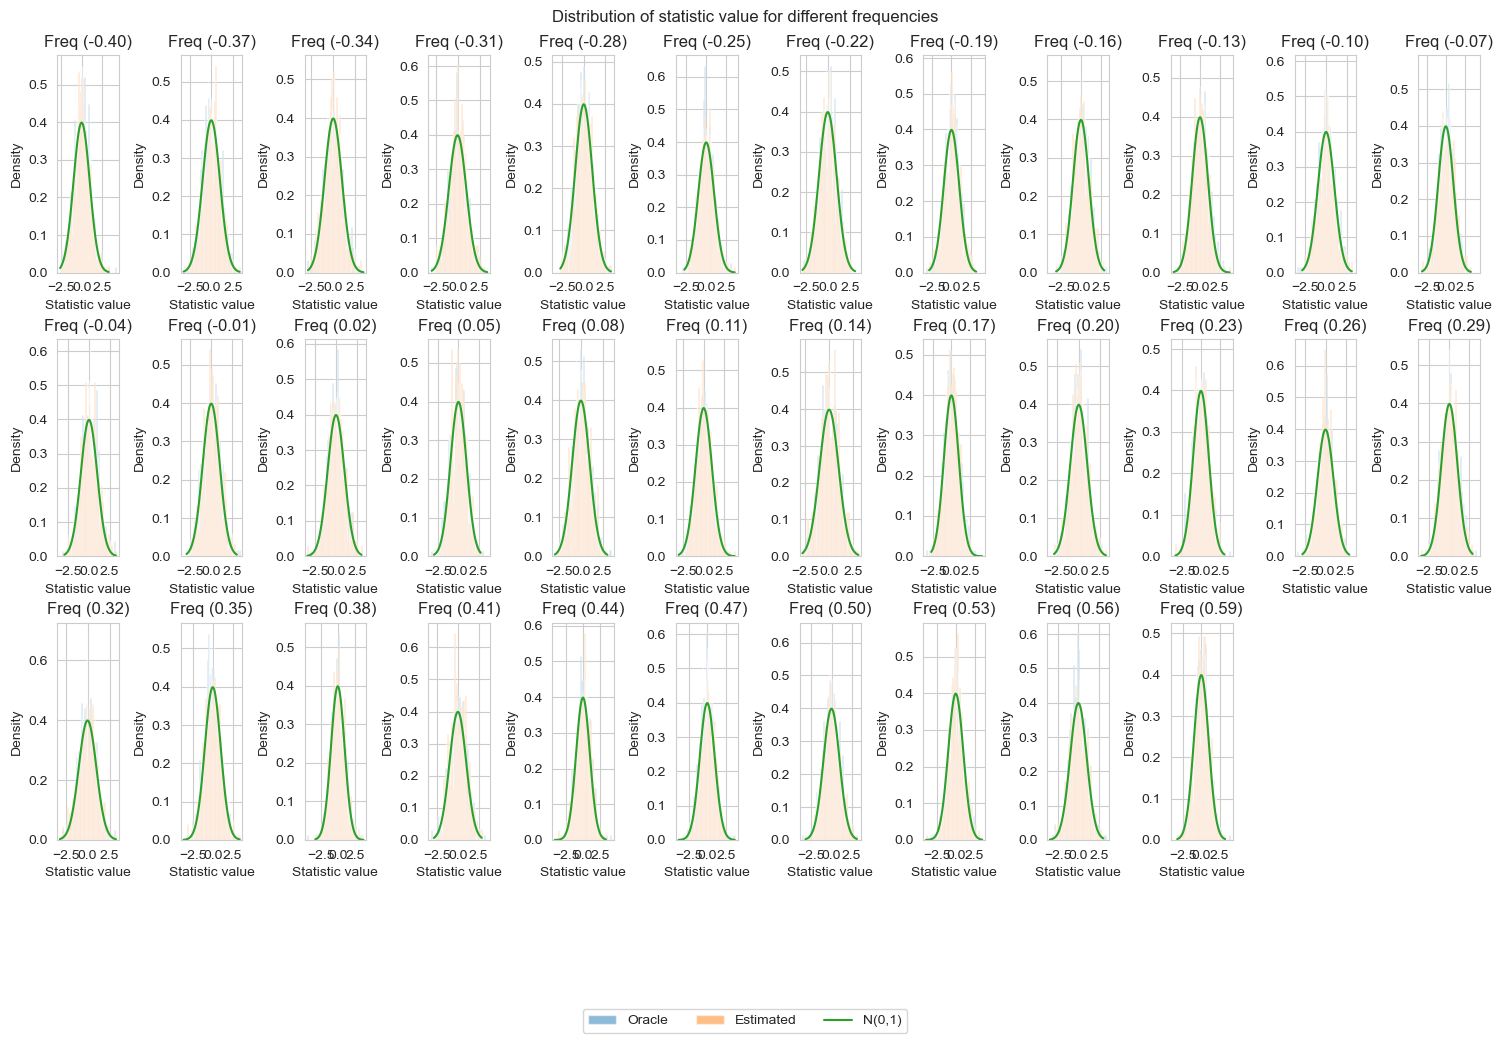

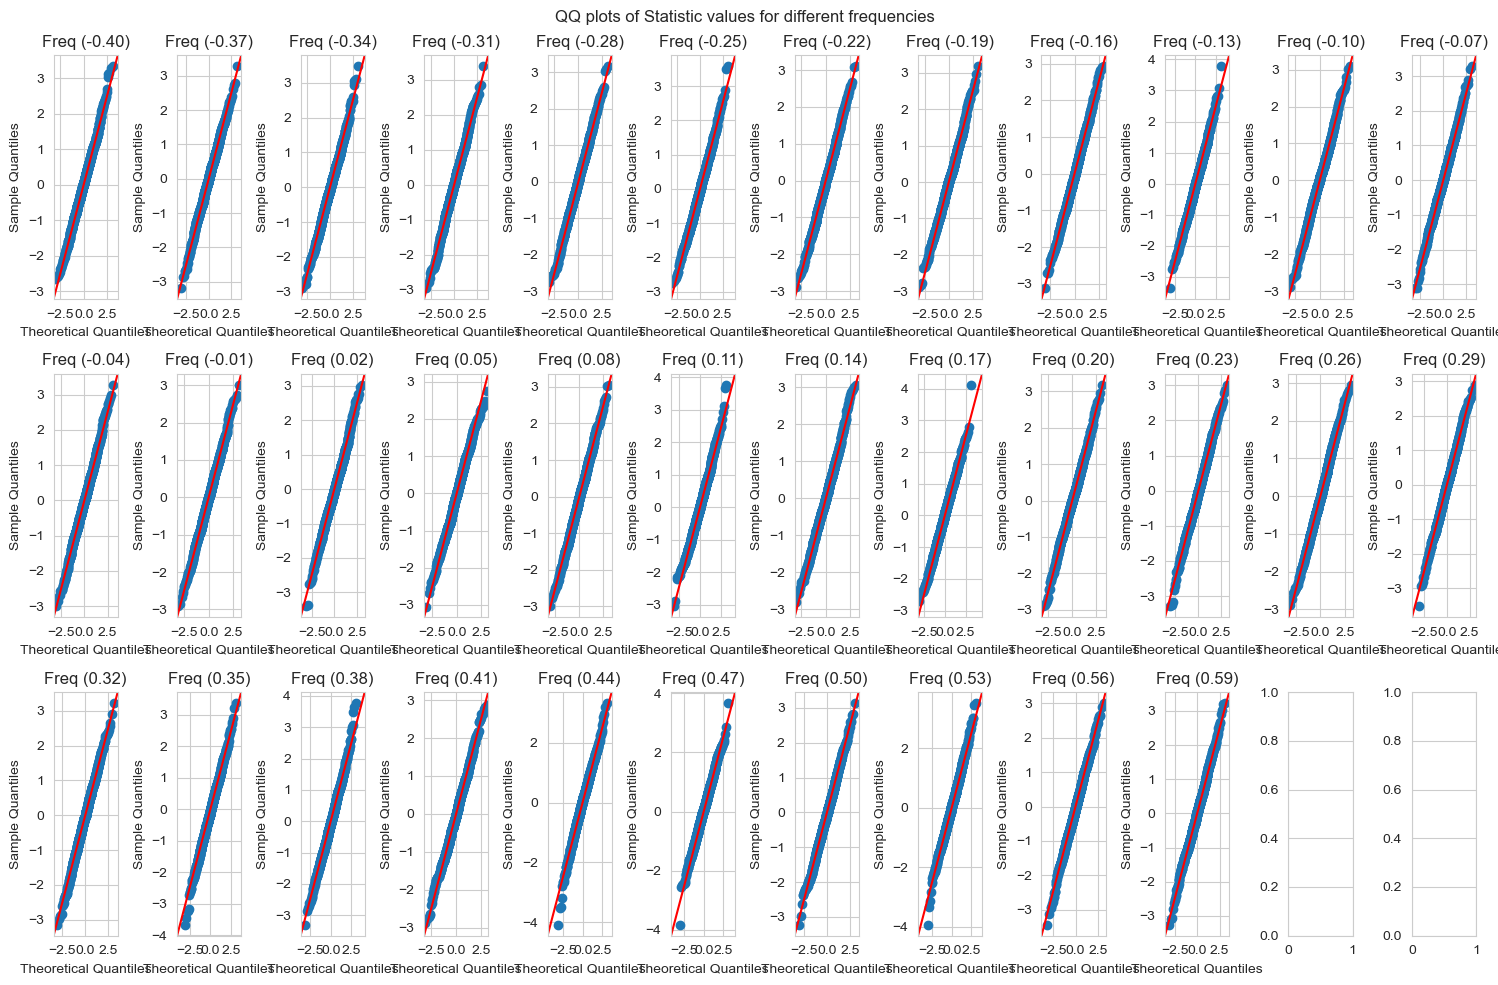

In [7]:
# plot distribution of t_stat_0
n_freqs = len(freqs)
fig, axs = plt.subplots(3, n_freqs // 3 + 1, figsize=(15, 10))
axs = axs.flatten()

# Create empty lists to store plot objects for the legend
oracle_plots = []
estimated_plots = []
normal_plots = []

for i in range(n_freqs):
    ax = axs[i]
    all_t_stat_0_oracle = np.array(
        [r["lrv"].t_stats_0[i] for r in gaussian_results if r["oracle_sd"] is not None]
    )
    all_t_stat_0_hat = np.array(
        [r["lrv"].t_stats_0[i] for r in gaussian_results if r["oracle_sd"] is None]
    )

    # Plot histograms
    oracle_plot = ax.hist(
        all_t_stat_0_oracle, bins=100, density=True, alpha=0.5, label="Oracle"
    )
    estimated_plot = ax.hist(
        all_t_stat_0_hat, bins=100, density=True, alpha=0.5, label="Estimated"
    )

    # Plot N(0,1) distribution
    x_range = np.linspace(np.min(all_t_stat_0_hat), np.max(all_t_stat_0_hat), 100)
    normal_plot = ax.plot(x_range, norm.pdf(x_range, 0, 1), label="N(0,1)")

    ax.set_title(f"Freq ({freqs[i]:.2f})")
    ax.set_xlabel("Statistic value")
    ax.set_ylabel("Density")

    # Store plot objects for the legend
    oracle_plots.append(oracle_plot[2][0])
    estimated_plots.append(estimated_plot[2][0])
    normal_plots.append(normal_plot[0])

# Remove empty subplots
for i in range(n_freqs, len(axs)):
    fig.delaxes(axs[i])

fig.suptitle("Distribution of statistic value for different frequencies")

plt.tight_layout()

# Add a single legend to the figure
fig.legend(
    [oracle_plots[0], estimated_plots[0], normal_plots[0]],
    ["Oracle", "Estimated", "N(0,1)"],
    loc="lower center",
    bbox_to_anchor=(0.5, -0.05),
    ncol=3,
)

# Adjust the layout to make room for the legend
plt.subplots_adjust(bottom=0.15)
plt.show()

fig, axs = plt.subplots(3, n_freqs // 3 + 1, figsize=(15, 10))
axs = axs.flatten()

for ax, i in zip(axs, range(n_freqs)):
    ax.set_title(f"Freq ({freqs[i]:.2f})")
    all_t_stat_0_oracle = np.array(
        [r["lrv"].t_stats_0[i] for r in gaussian_results if r["oracle_sd"] is not None]
    )
    all_t_stat_0_hat = np.array(
        [r["lrv"].t_stats_0[i] for r in gaussian_results if r["oracle_sd"] is None]
    )
    qqplot(all_t_stat_0_hat, dist=norm, line="45", ax=ax)

# add a global title
fig.suptitle("QQ plots of Statistic values for different frequencies")

# tight layout
plt.tight_layout()
plt.show()

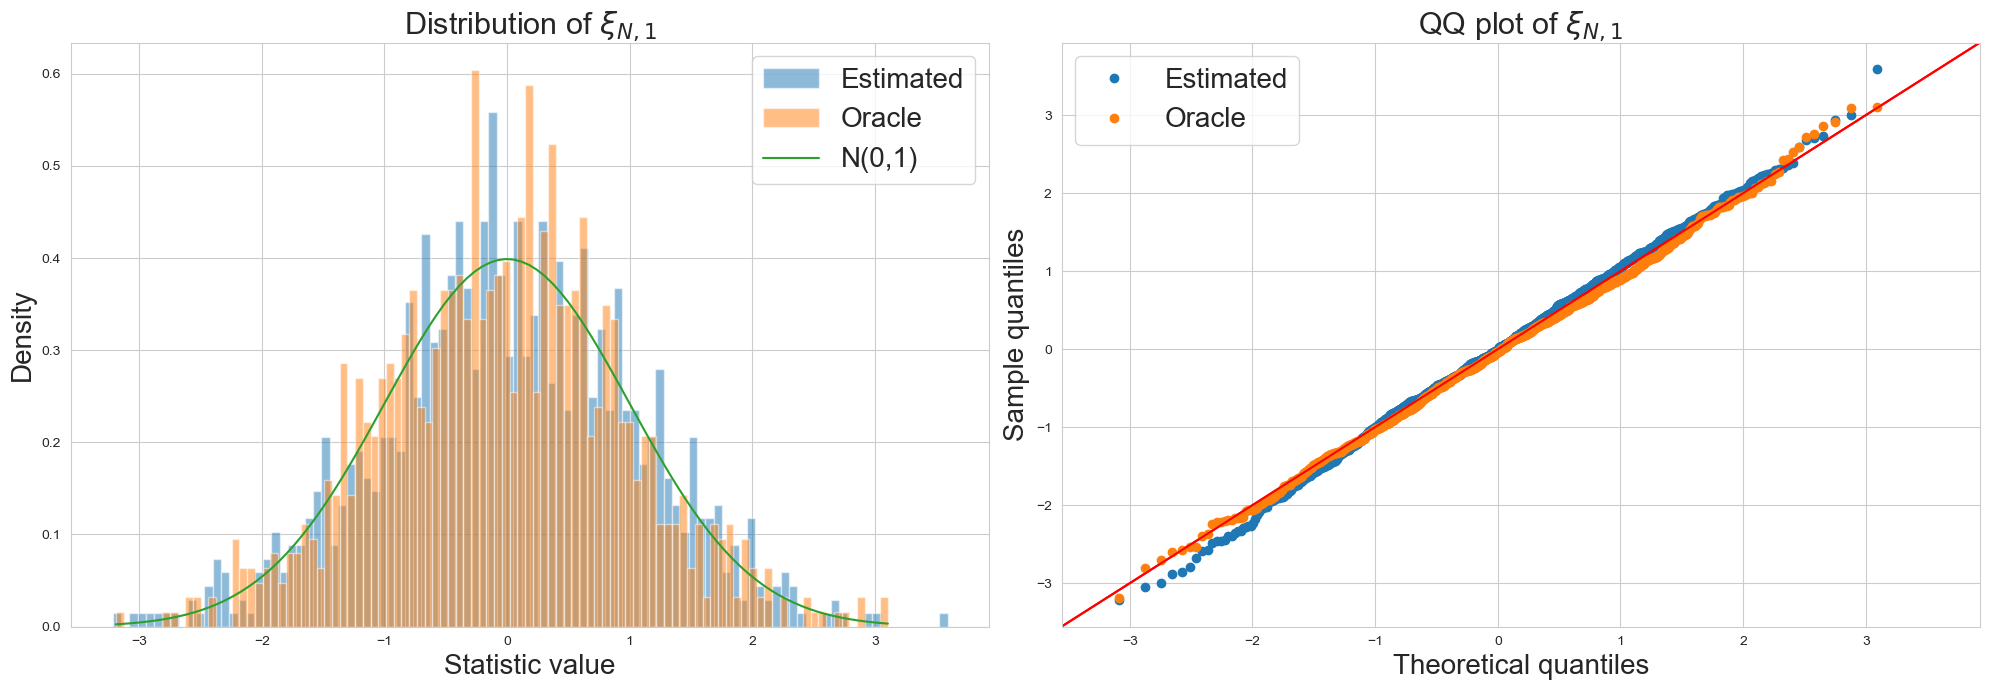

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(2 * 10, 7))

# plot distribution of t_stat_1
ax = axs[0]
all_t_stat_1_oracle = np.array(
    [r["lrv"].t_stat_1 for r in gaussian_results if r["oracle_sd"] is not None]
)
all_t_stat_1_hat = np.array(
    [r["lrv"].t_stat_1 for r in gaussian_results if r["oracle_sd"] is None]
)
ax.hist(all_t_stat_1_hat, bins=100, density=True, alpha=0.5, label="Estimated")
ax.hist(all_t_stat_1_oracle, bins=100, density=True, alpha=0.5, label="Oracle")
x_range = np.linspace(np.min(all_t_stat_1_oracle), np.max(all_t_stat_1_oracle), 100)
ax.plot(x_range, norm.pdf(x_range, 0, 1), label="N(0,1)")
ax.legend(fontsize=20)
ax.set_title(r"Distribution of $\xi_{N, 1}$", fontsize=22)
ax.set_xlabel("Statistic value", fontsize=20)
ax.set_ylabel("Density", fontsize=20)

ax = axs[1]
qqplot(
    all_t_stat_1_hat,
    dist=norm,
    line="45",
    ax=ax,
    marker="o",
    markerfacecolor="tab:blue",
    markeredgecolor="tab:blue",
    label="Estimated",
)
qqplot(
    all_t_stat_1_oracle,
    dist=norm,
    line="45",
    ax=ax,
    marker="o",
    markerfacecolor="tab:orange",
    markeredgecolor="tab:orange",
    label="Oracle",
)
ax.set_title(r"QQ plot of $\xi_{N, 1}$", fontsize=22)
ax.set_xlabel("Theoretical quantiles", fontsize=20)
ax.set_ylabel("Sample quantiles", fontsize=20)
ax.legend(fontsize=20)

plt.tight_layout()
plt.show()

fig.savefig(storage_path / "zeta-1-distribution.png")

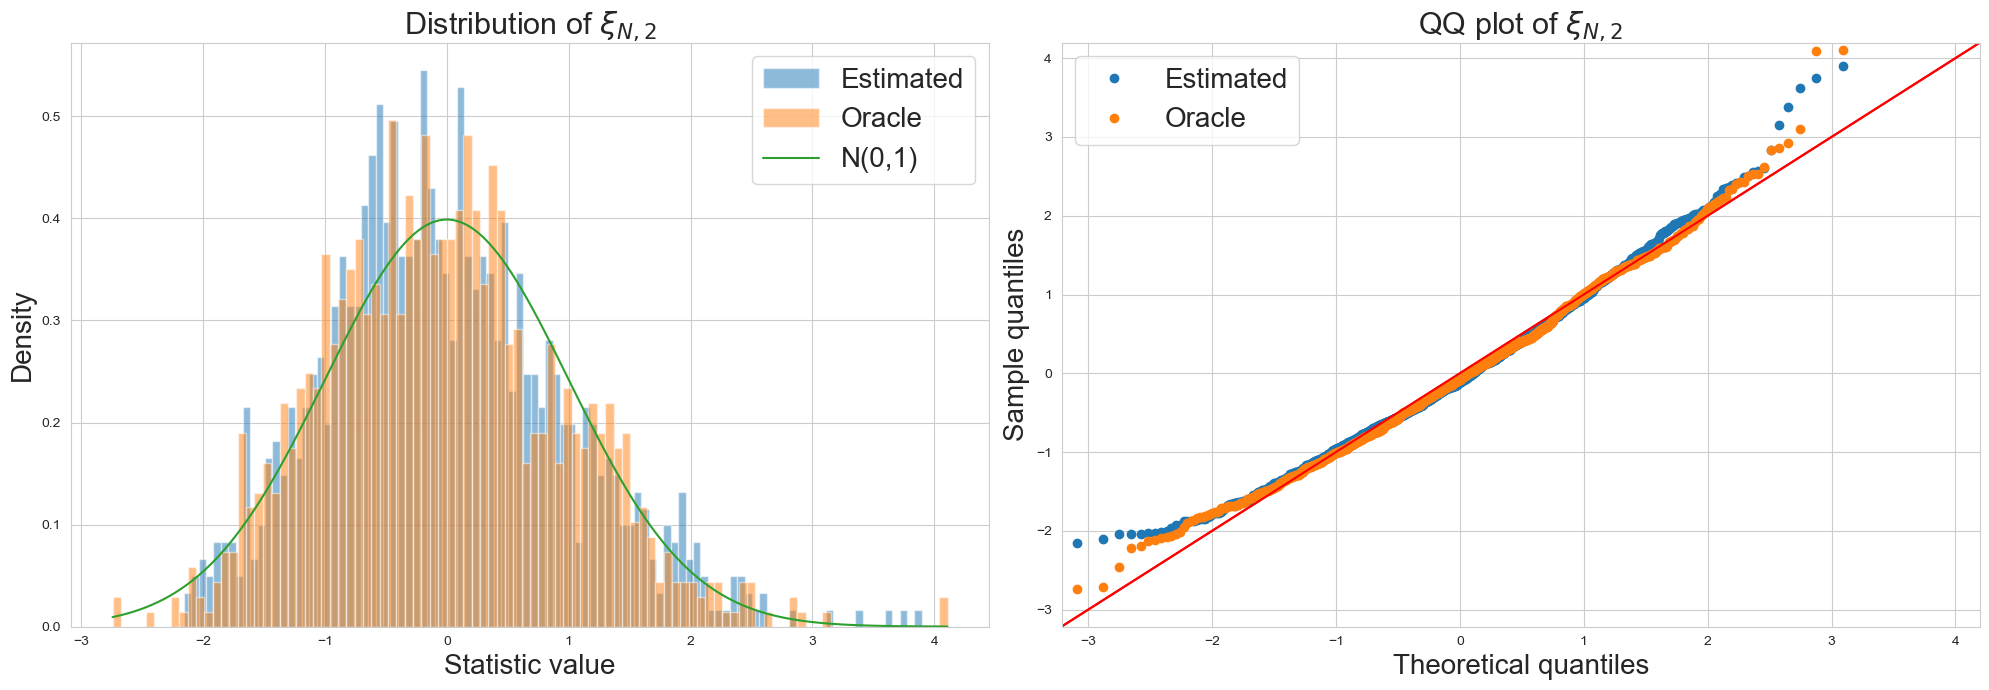

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(2 * 10, 7))

# Plot t_stat_2 values against N(0,1)
ax = axs[0]
n_freqs = len(freqs)
all_t_stat_2_oracle = np.array(
    [r["lrv"].t_stat_2 for r in gaussian_results if r["oracle_sd"] is not None]
)
all_t_stat_2_hat = np.array(
    [r["lrv"].t_stat_2 for r in gaussian_results if r["oracle_sd"] is None]
)
ax.hist(all_t_stat_2_hat, bins=100, density=True, alpha=0.5, label="Estimated")
ax.hist(all_t_stat_2_oracle, bins=100, density=True, alpha=0.5, label="Oracle")
x_range = np.linspace(
    np.min([all_t_stat_2_oracle, all_t_stat_2_hat]),
    np.max([all_t_stat_2_oracle, all_t_stat_2_hat]),
    1000,
)
ax.plot(x_range, norm.pdf(x_range, 0, 1), label="N(0,1)")

ax.set_title(r"Distribution of $\xi_{N, 2}$", fontsize=22)
ax.set_xlabel("Statistic value", fontsize=20)
ax.set_ylabel("Density", fontsize=20)
ax.legend(fontsize=20)

# in another graph, show the qqplot of t_stat_2
ax = axs[1]
qqplot(
    all_t_stat_2_hat,
    dist=norm,
    line="45",
    ax=ax,
    marker="o",
    markerfacecolor="tab:blue",
    markeredgecolor="tab:blue",
    label="Estimated",
)
qqplot(
    all_t_stat_2_oracle,
    dist=norm,
    line="45",
    ax=ax,
    marker="o",
    markerfacecolor="tab:orange",
    markeredgecolor="tab:orange",
    label="Oracle",
)
ax.legend(fontsize=20)
ax.set_title(r"QQ plot of $\xi_{N, 2}$", fontsize=22)
ax.set_xlabel("Theoretical quantiles", fontsize=20)
ax.set_ylabel("Sample quantiles", fontsize=20)

plt.tight_layout()
plt.show()

fig.savefig(storage_path / "zeta-2-distribution-against-normal.png")

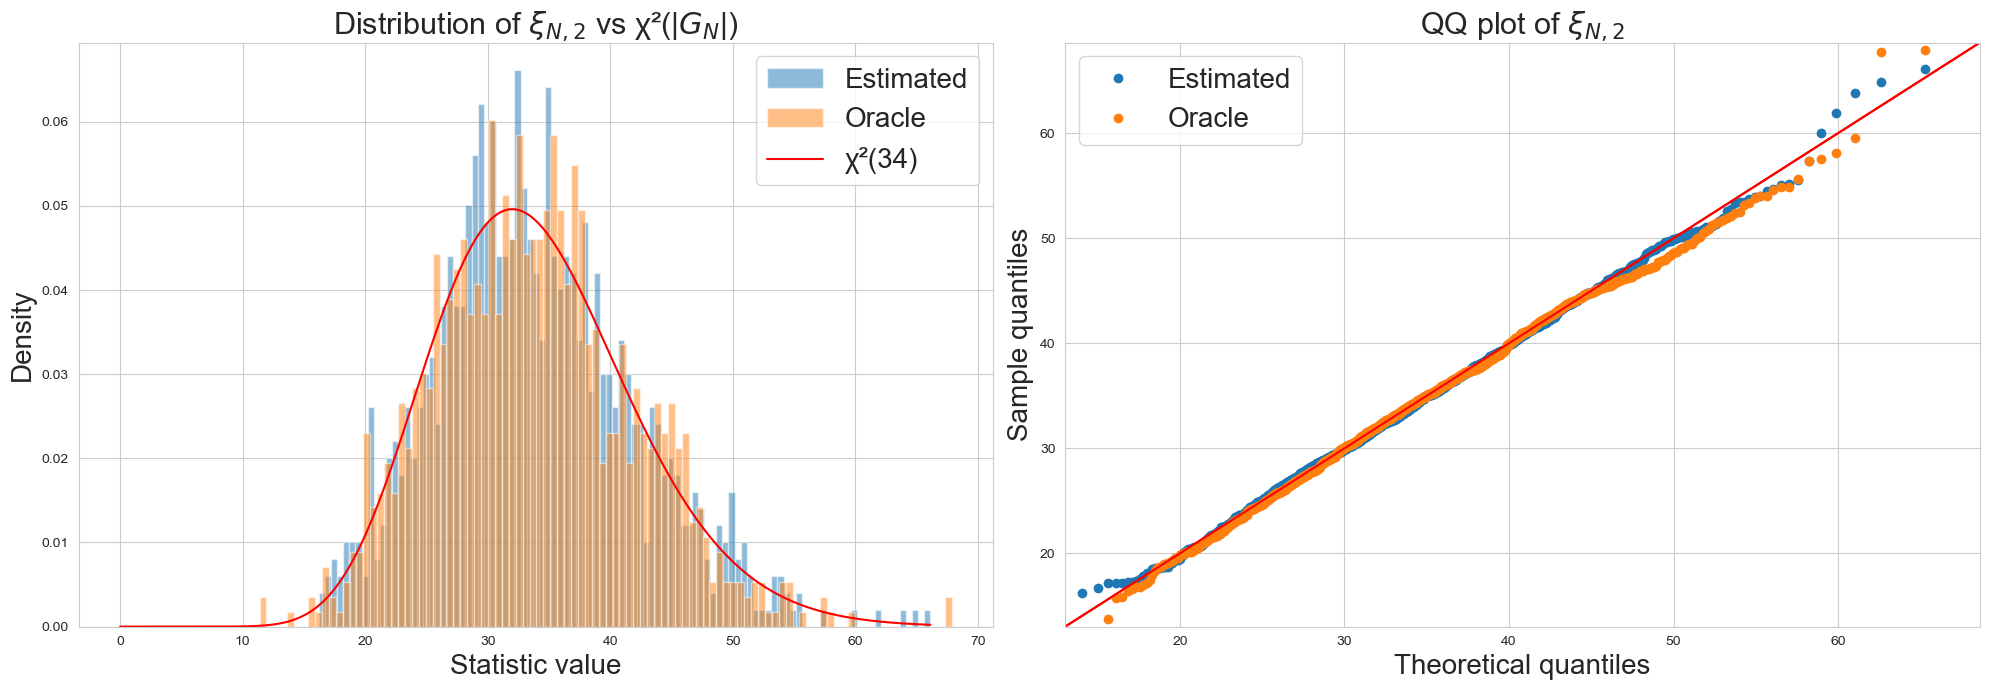

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(2 * 10, 7))

# Plot t_stat_3 values against chi2
ax = axs[0]
n_freqs = len(freqs)
all_t_stat_3_oracle = np.array(
    [r["lrv"].t_stat_3 for r in gaussian_results if r["oracle_sd"] is not None]
)
all_t_stat_3_hat = np.array(
    [r["lrv"].t_stat_3 for r in gaussian_results if r["oracle_sd"] is None]
)
ax.hist(all_t_stat_3_hat, bins=100, density=True, alpha=0.5, label="Estimated")
ax.hist(all_t_stat_3_oracle, bins=100, density=True, alpha=0.5, label="Oracle")
x_range = np.linspace(0, np.max(all_t_stat_3_hat), 1000)
ax.plot(x_range, chi2.pdf(x_range, df=n_freqs), label=f"χ²({n_freqs})", color="red")

ax.set_title(r"Distribution of $\xi_{N,2}$ vs χ²(|$G_N$|)", fontsize=22)
ax.set_xlabel("Statistic value", fontsize=20)
ax.set_ylabel("Density", fontsize=20)
ax.legend(fontsize=20)

# in another graph, show the qqplot of t_stat_3
ax = axs[1]
qqplot(
    all_t_stat_3_hat,
    dist=chi2,
    distargs=(n_freqs,),
    line="45",
    ax=ax,
    marker="o",
    markerfacecolor="tab:blue",
    markeredgecolor="tab:blue",
    label="Estimated",
)
qqplot(
    all_t_stat_3_oracle,
    dist=chi2,
    distargs=(n_freqs,),
    line="45",
    ax=ax,
    marker="o",
    markerfacecolor="tab:orange",
    markeredgecolor="tab:orange",
    label="Oracle",
)
ax.legend(fontsize=20)
ax.set_title(r"QQ plot of $\xi_{N, 2}$", fontsize=22)
ax.set_xlabel("Theoretical quantiles", fontsize=20)
ax.set_ylabel("Sample quantiles", fontsize=20)

plt.tight_layout()
plt.show()

fig.savefig(storage_path / "zeta-2-distribution-against-chi2.png")

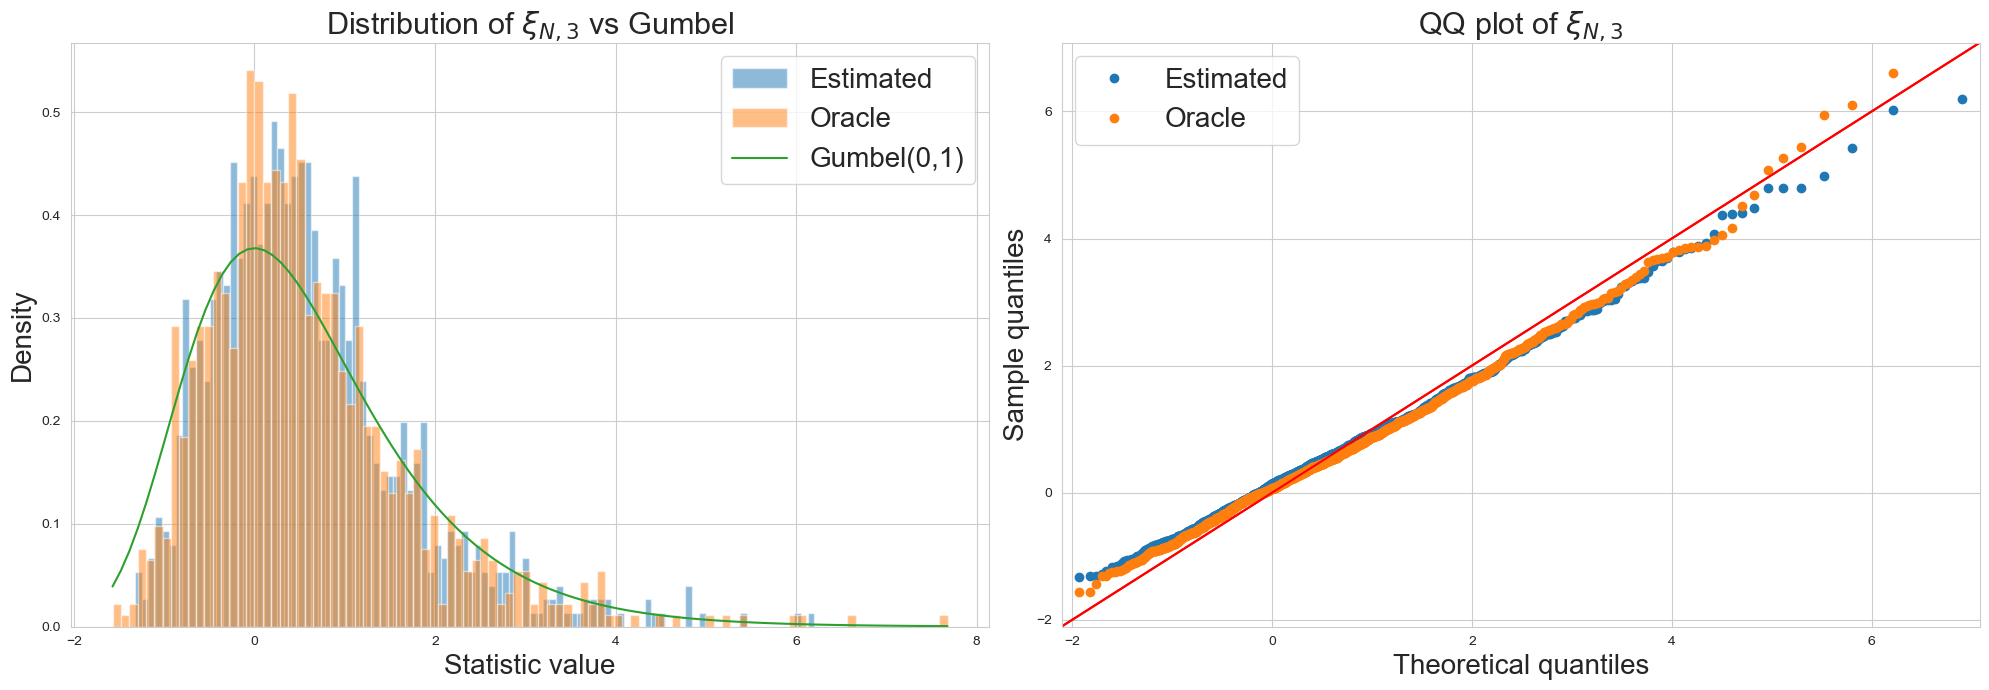

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(2 * 10, 7))

# plot t_stat_4 against Gumbel
ax = axs[0]
all_t_stat_4_oracle = np.array(
    [r["lrv"].t_stat_4 for r in gaussian_results if r["oracle_sd"] is not None]
)
all_t_stat_4_hat = np.array(
    [r["lrv"].t_stat_4 for r in gaussian_results if r["oracle_sd"] is None]
)
ax.hist(all_t_stat_4_hat, bins=100, density=True, alpha=0.5, label="Estimated")
ax.hist(all_t_stat_4_oracle, bins=100, density=True, alpha=0.5, label="Oracle")
x_range = np.linspace(
    np.min([all_t_stat_4_oracle, all_t_stat_4_hat]),
    np.max([all_t_stat_4_oracle, all_t_stat_4_hat]),
    100,
)
ax.plot(x_range, gumbel_r.pdf(x_range), label="Gumbel(0,1)")
ax.legend(fontsize=20)
ax.set_title(r"Distribution of $\xi_{N,3}$ vs Gumbel", fontsize=22)
ax.set_xlabel("Statistic value", fontsize=20)
ax.set_ylabel("Density", fontsize=20)

ax = axs[1]
qqplot(
    all_t_stat_4_hat,
    dist=gumbel_r,
    line="45",
    ax=ax,
    marker="o",
    markerfacecolor="tab:blue",
    markeredgecolor="tab:blue",
    label="Estimated",
)
qqplot(
    all_t_stat_4_oracle,
    dist=gumbel_r,
    line="45",
    ax=ax,
    marker="o",
    markerfacecolor="tab:orange",
    markeredgecolor="tab:orange",
    label="Oracle",
)
ax.legend(fontsize=20)
ax.set_title(r"QQ plot of $\xi_{N,3}$", fontsize=22)
ax.set_xlabel("Theoretical quantiles", fontsize=20)
ax.set_ylabel("Sample quantiles", fontsize=20)

plt.tight_layout()
plt.show()

fig.savefig(storage_path / "zeta-4-distribution-against-gumbel.png")

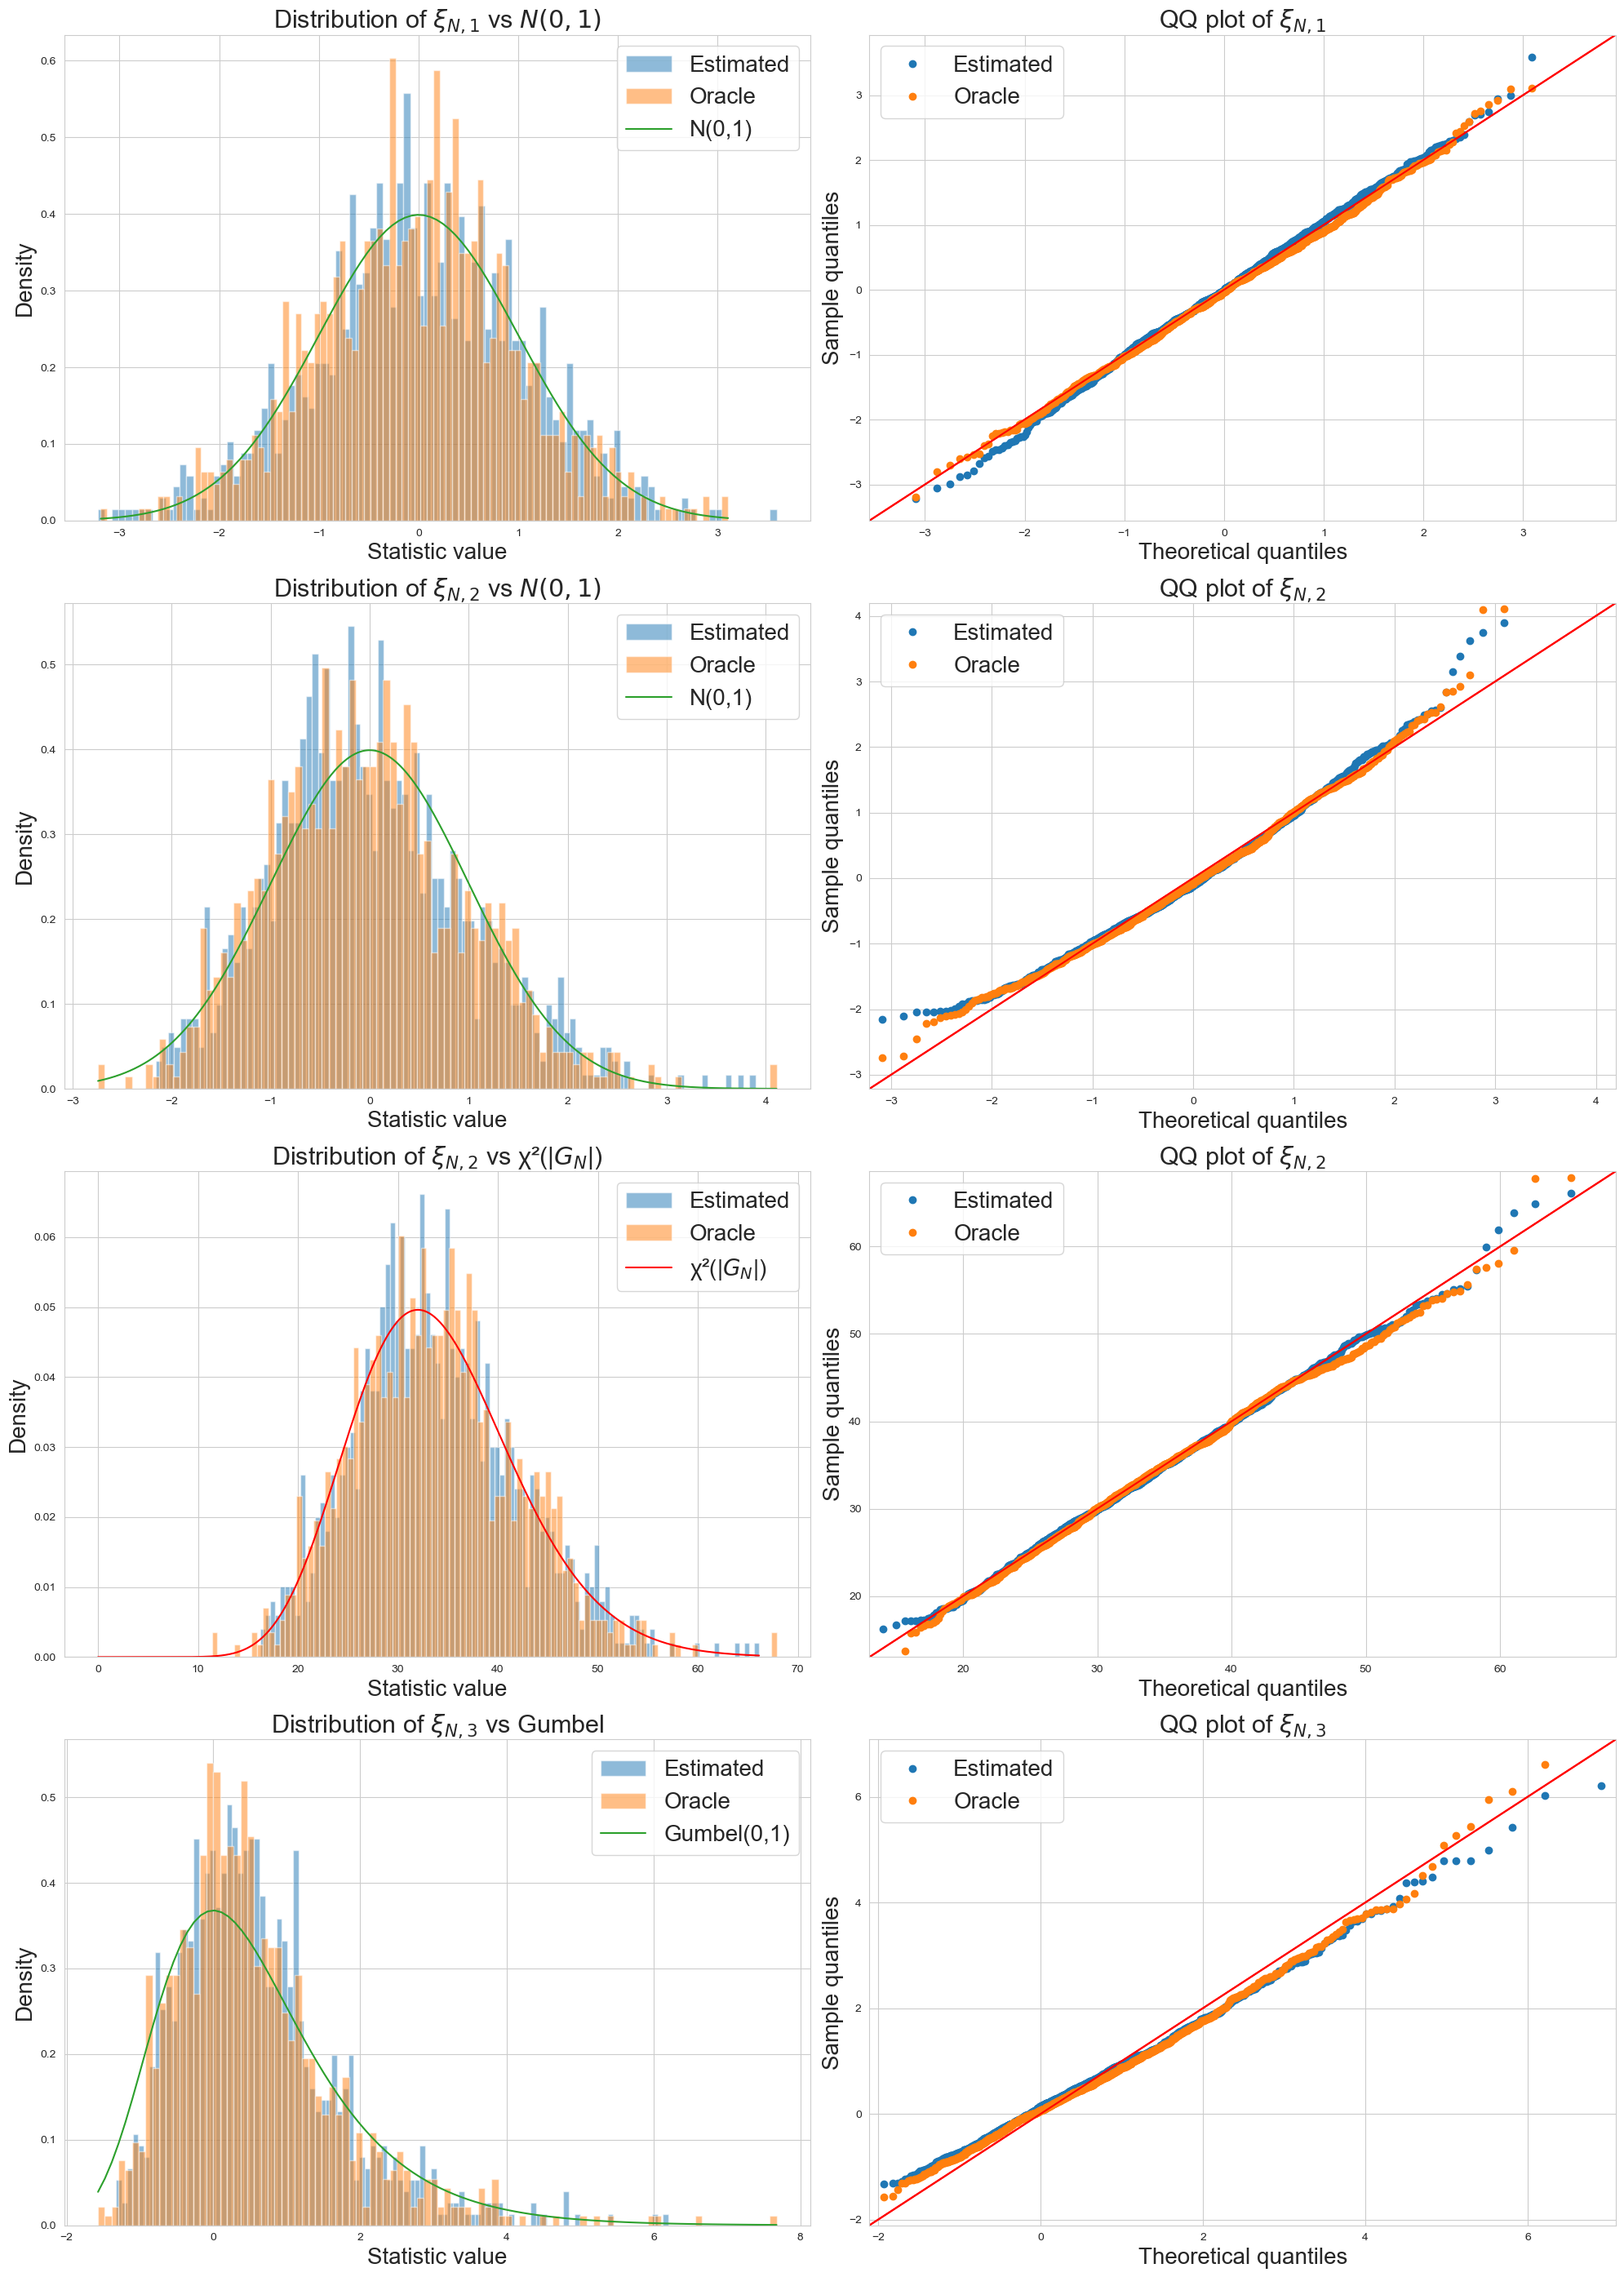

In [12]:
fig, axs = plt.subplots(4, 2, figsize=(2 * 10, 7 * 4))

# plot distribution of t_stat_1
ax = axs[0, 0]
all_t_stat_1_oracle = np.array(
    [r["lrv"].t_stat_1 for r in gaussian_results if r["oracle_sd"] is not None]
)
all_t_stat_1_hat = np.array(
    [r["lrv"].t_stat_1 for r in gaussian_results if r["oracle_sd"] is None]
)
ax.hist(all_t_stat_1_hat, bins=100, density=True, alpha=0.5, label="Estimated")
ax.hist(all_t_stat_1_oracle, bins=100, density=True, alpha=0.5, label="Oracle")
x_range = np.linspace(np.min(all_t_stat_1_oracle), np.max(all_t_stat_1_oracle), 100)
ax.plot(x_range, norm.pdf(x_range, 0, 1), label="N(0,1)")
ax.legend(fontsize=20)
ax.set_title(r"Distribution of $\xi_{N, 1}$ vs $N(0,1)$", fontsize=22)
ax.set_xlabel("Statistic value", fontsize=20)
ax.set_ylabel("Density", fontsize=20)

ax = axs[0, 1]
qqplot(
    all_t_stat_1_hat,
    dist=norm,
    line="45",
    ax=ax,
    marker="o",
    markerfacecolor="tab:blue",
    markeredgecolor="tab:blue",
    label="Estimated",
)
qqplot(
    all_t_stat_1_oracle,
    dist=norm,
    line="45",
    ax=ax,
    marker="o",
    markerfacecolor="tab:orange",
    markeredgecolor="tab:orange",
    label="Oracle",
)
ax.set_title(r"QQ plot of $\xi_{N, 1}$", fontsize=22)
ax.set_xlabel("Theoretical quantiles", fontsize=20)
ax.set_ylabel("Sample quantiles", fontsize=20)
ax.legend(fontsize=20)


#######

# Plot t_stat_2 values against N(0,1)
ax = axs[1, 0]
n_freqs = len(freqs)
all_t_stat_2_oracle = np.array(
    [r["lrv"].t_stat_2 for r in gaussian_results if r["oracle_sd"] is not None]
)
all_t_stat_2_hat = np.array(
    [r["lrv"].t_stat_2 for r in gaussian_results if r["oracle_sd"] is None]
)
ax.hist(all_t_stat_2_hat, bins=100, density=True, alpha=0.5, label="Estimated")
ax.hist(all_t_stat_2_oracle, bins=100, density=True, alpha=0.5, label="Oracle")
x_range = np.linspace(
    np.min([all_t_stat_2_oracle, all_t_stat_2_hat]),
    np.max([all_t_stat_2_oracle, all_t_stat_2_hat]),
    1000,
)
ax.plot(x_range, norm.pdf(x_range, 0, 1), label="N(0,1)")

ax.set_title(r"Distribution of $\xi_{N, 2}$ vs $N(0,1)$", fontsize=22)
ax.set_xlabel("Statistic value", fontsize=20)
ax.set_ylabel("Density", fontsize=20)
ax.legend(fontsize=20)

# in another graph, show the qqplot of t_stat_2
ax = axs[1, 1]
qqplot(
    all_t_stat_2_hat,
    dist=norm,
    line="45",
    ax=ax,
    marker="o",
    markerfacecolor="tab:blue",
    markeredgecolor="tab:blue",
    label="Estimated",
)
qqplot(
    all_t_stat_2_oracle,
    dist=norm,
    line="45",
    ax=ax,
    marker="o",
    markerfacecolor="tab:orange",
    markeredgecolor="tab:orange",
    label="Oracle",
)
ax.legend(fontsize=20)
ax.set_title(r"QQ plot of $\xi_{N, 2}$", fontsize=22)
ax.set_xlabel("Theoretical quantiles", fontsize=20)
ax.set_ylabel("Sample quantiles", fontsize=20)


##############

# Plot t_stat_3 values against chi2
ax = axs[2, 0]
n_freqs = len(freqs)
all_t_stat_3_oracle = np.array(
    [r["lrv"].t_stat_3 for r in gaussian_results if r["oracle_sd"] is not None]
)
all_t_stat_3_hat = np.array(
    [r["lrv"].t_stat_3 for r in gaussian_results if r["oracle_sd"] is None]
)
ax.hist(all_t_stat_3_hat, bins=100, density=True, alpha=0.5, label="Estimated")
ax.hist(all_t_stat_3_oracle, bins=100, density=True, alpha=0.5, label="Oracle")
x_range = np.linspace(0, np.max(all_t_stat_3_hat), 1000)
ax.plot(x_range, chi2.pdf(x_range, df=n_freqs), label=r"χ²(|$G_N$|)", color="red")

ax.set_title(r"Distribution of $\xi_{N,2}$ vs χ²(|$G_N$|)", fontsize=22)
ax.set_xlabel("Statistic value", fontsize=20)
ax.set_ylabel("Density", fontsize=20)
ax.legend(fontsize=20)

# in another graph, show the qqplot of t_stat_3
ax = axs[2, 1]
qqplot(
    all_t_stat_3_hat,
    dist=chi2,
    distargs=(n_freqs,),
    line="45",
    ax=ax,
    marker="o",
    markerfacecolor="tab:blue",
    markeredgecolor="tab:blue",
    label="Estimated",
)
qqplot(
    all_t_stat_3_oracle,
    dist=chi2,
    distargs=(n_freqs,),
    line="45",
    ax=ax,
    marker="o",
    markerfacecolor="tab:orange",
    markeredgecolor="tab:orange",
    label="Oracle",
)
ax.legend(fontsize=20)
ax.set_title(r"QQ plot of $\xi_{N, 2}$", fontsize=22)
ax.set_xlabel("Theoretical quantiles", fontsize=20)
ax.set_ylabel("Sample quantiles", fontsize=20)


#################


# plot t_stat_4 against Gumbel
ax = axs[3, 0]
all_t_stat_4_oracle = np.array(
    [r["lrv"].t_stat_4 for r in gaussian_results if r["oracle_sd"] is not None]
)
all_t_stat_4_hat = np.array(
    [r["lrv"].t_stat_4 for r in gaussian_results if r["oracle_sd"] is None]
)
ax.hist(all_t_stat_4_hat, bins=100, density=True, alpha=0.5, label="Estimated")
ax.hist(all_t_stat_4_oracle, bins=100, density=True, alpha=0.5, label="Oracle")
x_range = np.linspace(
    np.min([all_t_stat_4_oracle, all_t_stat_4_hat]),
    np.max([all_t_stat_4_oracle, all_t_stat_4_hat]),
    100,
)
ax.plot(x_range, gumbel_r.pdf(x_range), label="Gumbel(0,1)")
ax.legend(fontsize=20)
ax.set_title(r"Distribution of $\xi_{N,3}$ vs Gumbel", fontsize=22)
ax.set_xlabel("Statistic value", fontsize=20)
ax.set_ylabel("Density", fontsize=20)

ax = axs[3, 1]
qqplot(
    all_t_stat_4_hat,
    dist=gumbel_r,
    line="45",
    ax=ax,
    marker="o",
    markerfacecolor="tab:blue",
    markeredgecolor="tab:blue",
    label="Estimated",
)
qqplot(
    all_t_stat_4_oracle,
    dist=gumbel_r,
    line="45",
    ax=ax,
    marker="o",
    markerfacecolor="tab:orange",
    markeredgecolor="tab:orange",
    label="Oracle",
)
ax.legend(fontsize=20)
ax.set_title(r"QQ plot of $\xi_{N,3}$", fontsize=22)
ax.set_xlabel("Theoretical quantiles", fontsize=20)
ax.set_ylabel("Sample quantiles", fontsize=20)


###########

plt.tight_layout()
plt.show()

fig.savefig(storage_path / "zeta-all-distribution.png")

# Non-gaussian analysis

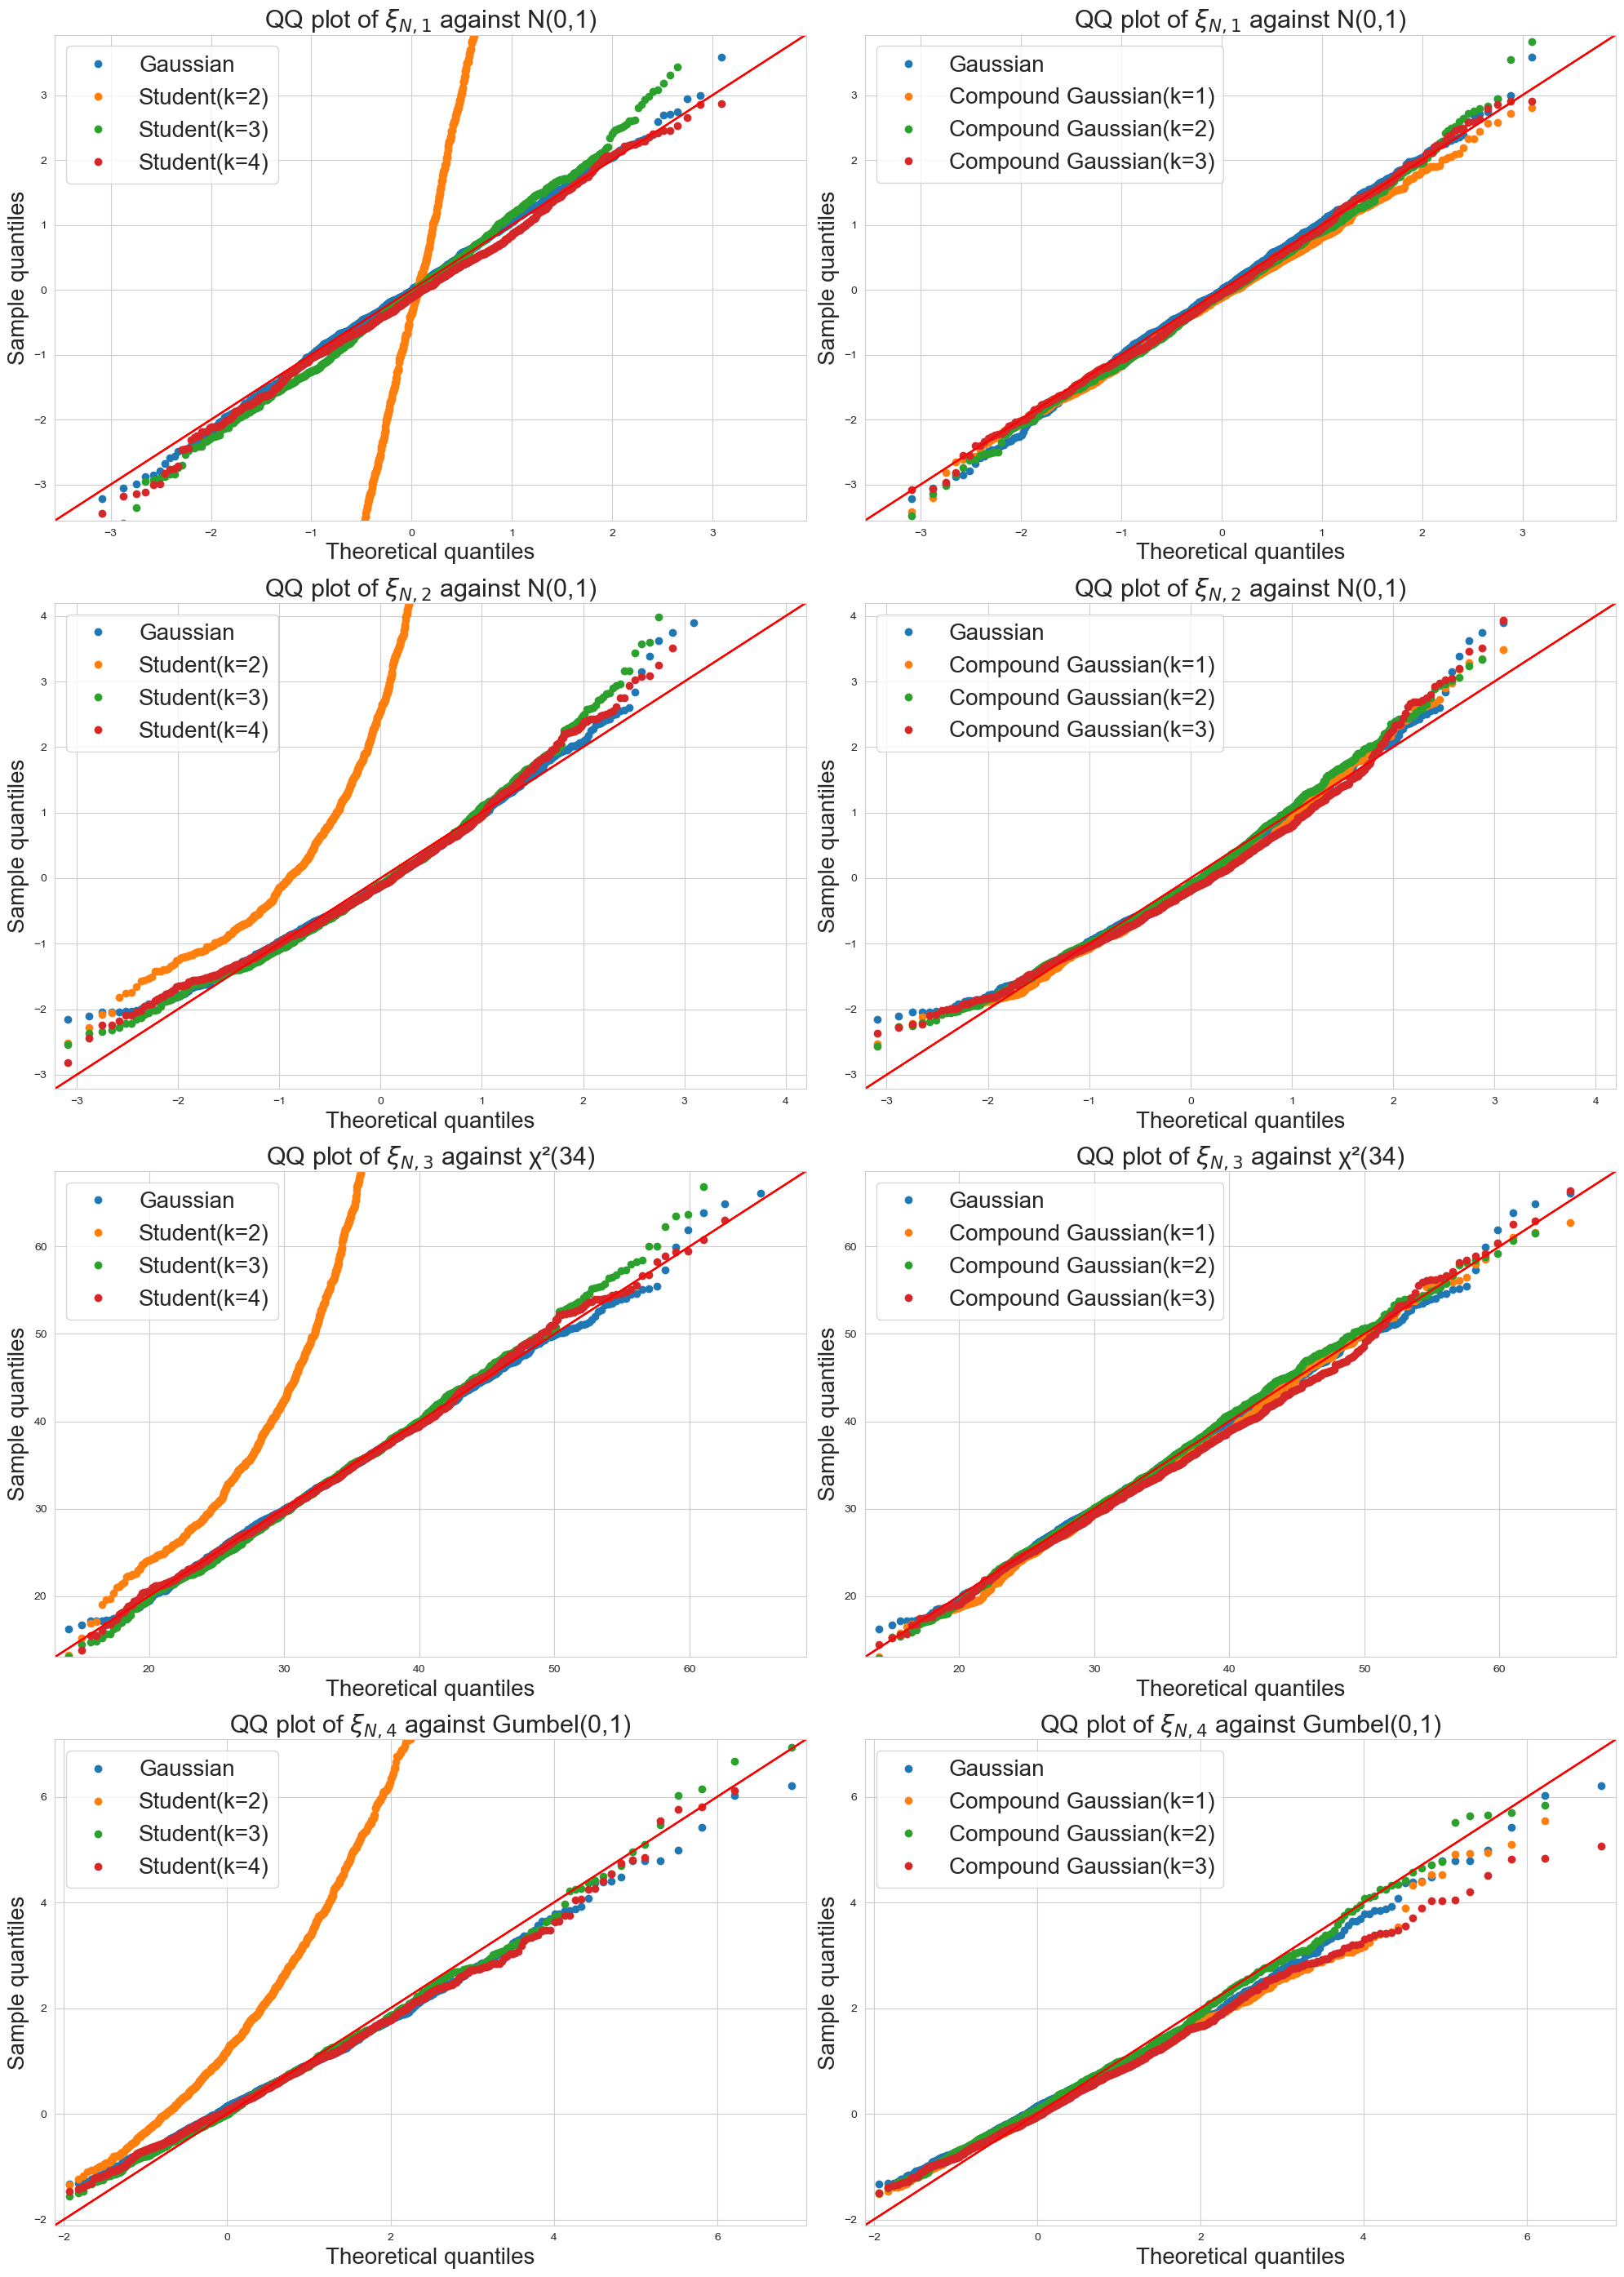

Exception ignored in: <function ResourceTracker.__del__ at 0x104fa3380>
Traceback (most recent call last):
  File "/Users/alexisrosuel/micromamba/envs/lrv313/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/Users/alexisrosuel/micromamba/envs/lrv313/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/Users/alexisrosuel/micromamba/envs/lrv313/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1051bf380>
Traceback (most recent call last):
  File "/Users/alexisrosuel/micromamba/envs/lrv313/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/Users/alexisrosuel/micromamba/envs/lrv313/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/Users/alexisrosuel/micromamba/envs/lrv313/lib/python3.13/multiprocessing/resource_tracker.py", line 116, i

In [ ]:
fig, axs = plt.subplots(4, 2, figsize=(2 * 10, 4 * 7))

n_freqs = len(freqs)

colors_non_gaussian = ["tab:orange", "tab:green", "tab:red"]
assert (
    len(colors_non_gaussian)
    == len(student_df_range)
    == len(coumpound_gaussian_shape_range)
)

# Start to plot the reference gaussian case
gaussian_results = [r for r in results if r["noise_func"] == "gaussian_sample"]
gaussian_results_hat = [r for r in gaussian_results if r["oracle_sd"] is None]

for row, dist, dist_args, t_stat in zip(
    range(4),
    [norm, norm, chi2, gumbel_r],
    [None, None, (n_freqs,), None],
    ["t_stat_1", "t_stat_2", "t_stat_3", "t_stat_4"],
):
    # Start to plot the gaussian results (used as reference)
    all_t_stat_hat = np.array([getattr(r["lrv"], t_stat) for r in gaussian_results_hat])
    for col in range(2):
        ax = axs[row, col]
        qqplot(
            all_t_stat_hat,
            dist=dist,
            distargs=dist_args,
            line="45",
            ax=ax,
            marker="o",
            markerfacecolor="tab:blue",
            markeredgecolor="tab:blue",
            label="Gaussian",
        )

    # then plot the non-gaussian results
    for col, noise_type in enumerate(["students_t_sample", "compound_gaussian_sample"]):
        if noise_type == "students_t_sample":
            curve_name = "Student"
            param_values = student_df_range
            param_name = "df"
        elif noise_type == "compound_gaussian_sample":
            curve_name = "Compound Gaussian"
            param_values = coumpound_gaussian_shape_range
            param_name = "shape"
        else:
            raise ValueError(f"Unknown noise type: {noise_type}")

        non_gaussian_results = [
            r
            for r in results
            if r["noise_func"] == noise_type and r["oracle_sd"] is None
        ]

        ax = axs[row, col]
        for param_i, param in enumerate(param_values):
            sub_results = [r for r in non_gaussian_results if r[param_name] == param]
            results_hat = [r for r in sub_results if r["oracle_sd"] is None]
            all_t_stat_hat = np.array([getattr(r["lrv"], t_stat) for r in results_hat])
            qqplot(
                all_t_stat_hat,
                dist=dist,
                distargs=dist_args,
                line="45",
                ax=ax,
                marker="o",
                markerfacecolor=colors_non_gaussian[param_i],
                markeredgecolor=colors_non_gaussian[param_i],
                label=f"{curve_name}(k={param})",
            )

            if row == 0:
                title_str = r"QQ plot of $\xi_{N, 1}$ against"
            elif row == 1:
                title_str = r"QQ plot of $\xi_{N, 2}$ against"
            elif row == 2:
                title_str = r"QQ plot of $\xi_{N, 3}$ against"
            elif row == 3:
                title_str = r"QQ plot of $\xi_{N, 4}$ against"

            if dist == chi2:
                title_str += f" χ²({n_freqs})"
            elif dist == gumbel_r:
                title_str += f" Gumbel(0,1)"
            elif dist == students_t_sample:
                title_str += f" t({dist_args[0]})"
            elif dist == norm:
                title_str += f" N(0,1)"

            ax.set_title(title_str, fontsize=22)
            ax.set_xlabel("Theoretical quantiles", fontsize=20)
            ax.set_ylabel("Sample quantiles", fontsize=20)
            ax.legend(fontsize=20)


#######


###########

plt.tight_layout()
plt.show()

fig.savefig(storage_path / "zeta-all-distribution-non-gaussian.png")